# Modelling - Vanilla Algorithms Gridsearch RF
Author: P.C.O. Maseland <br>
Date: 03 December 2021 <br>

In [1]:
# !!! RUN !!!
#Import packages/libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Random forest packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Load Correct datafile

**prepared accelerometer, gyroscope and magnetometer csv**

In [2]:
# !!! RUN !!!
#local jupyter notebook path
path ="Totalset+slopes+mean+sd.csv"
df = pd.read_csv(path)

In [3]:
df.head(100)

,magnitude_chest_acc,magnitude_forearm_acc,magnitude_head_acc,magnitude_shin_acc,magnitude_thigh_acc,magnitude_upperarm_acc,magnitude_waist_acc,magnitude_chest_gyr,magnitude_forearm_gyr,magnitude_head_gyr,...,magnitude_head_mag_mean,magnitude_head_mag_sd,magnitude_shin_mag_mean,magnitude_shin_mag_sd,magnitude_thigh_mag_mean,magnitude_thigh_mag_sd,magnitude_upperarm_mag_mean,magnitude_upperarm_mag_sd,magnitude_waist_mag_mean,magnitude_waist_mag_sd
0,9.771236,9.787128,9.684595,10.100332,9.532843,10.154984,9.825808,0.038048,0.005705,0.069351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.803299,9.830025,9.652884,10.090979,9.538804,10.144928,9.820284,0.036161,0.009607,0.063729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.828618,9.848948,9.723963,10.092054,9.538612,10.162209,9.807764,0.037268,0.008487,0.067978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.672613,9.831390,9.775289,10.098940,9.530453,10.222147,9.857982,0.051724,0.008386,0.075489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.800911,9.879557,9.749285,10.089414,9.536494,10.269088,9.843884,0.050047,0.014337,0.092244,...,50.880480,0.000000e+00,39.744127,0.0,43.489173,0.000000,49.108764,0.0,49.129630,0.068392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.813382,9.843272,9.728845,10.123720,9.531407,10.199592,9.815353,0.074777,0.050545,0.062284,...,50.814043,1.935957e-01,39.966902,0.0,43.415478,0.134441,49.179638,0.0,49.233537,0.398488
96,9.758835,9.837921,9.746465,10.113368,9.523090,10.203853,9.887570,0.073352,0.051339,0.061273,...,50.896380,1.215304e-01,39.966902,0.0,43.355354,0.164656,49.179638,0.0,49.300787,0.332561
97,9.761502,9.849287,9.751139,10.105277,9.542320,10.198063,9.895177,0.069118,0.048489,0.064585,...,50.950730,1.795787e-07,39.966902,0.0,43.295230,0.164656,49.179638,0.0,49.298018,0.334056
98,9.816022,9.838173,9.704408,10.108862,9.533452,10.224991,9.815756,0.056011,0.047734,0.058587,...,50.950730,1.795787e-07,39.966902,0.0,43.235106,0.134441,49.179638,0.0,49.148624,0.000000


In [3]:
# !!! RUN !!!
#reorder such that labels are at the back
df = df[[c for c in df if c not in ['Subject ID','Activity']] 
       + ['Subject ID','Activity']]

### Remove/Convert statistical NaN values
Since we calculated our rolled statistics over a nr of timesteps. The first nr of timesteps have a NaN, these are therefore useless. On the whole set we removed thereby 24336 rows, which is just a small fraction of 0.4% of the whole.

In [4]:
df.shape

(6084000, 86)

In [4]:
# !!! RUN !!!
df = df. dropna()

In [6]:
df.shape

(6059664, 86)

In [9]:
#removed rows. %loss
((6084000 - 6059664) /6084000)*100

0.4

### Full set copy

In [5]:
# !!! RUN !!!
#create copy full set
fullset = df
print(fullset.shape)

#drop subject ID
fullset_without_subject = fullset.drop(columns=['Subject ID'])

#shuffle fullset
fullset_without_subject = fullset_without_subject.sample(frac=1)

(6059664, 86)


### Reduce size of set for computation


In [6]:
# !!! RUN !!!
#take 10% of the data just for computational advantages, just experimenting
size_subset = 0.1
fullset_without_subject = fullset.drop(columns=['Subject ID'])

#shuffle fullset
fullset_without_subject = fullset_without_subject.sample(frac=1)
subset_without_subject = fullset_without_subject[0:round(len(df)*size_subset)]

print(subset_without_subject.shape)
print(type(subset_without_subject))

(605966, 85)
<class 'pandas.core.frame.DataFrame'>


In [27]:
#shuffle subset
subset_without_subject = subset_without_subject.sample(frac=1)

### Make new subset
With only time-base statistical values

In [7]:
# !!! RUN !!!
statistical_cols = [col for col in fullset_without_subject.columns if ('slope' in col 
                                                                      or 'mean' in col 
                                                                      or 'sd' in col
                                                                      or 'Activity' in col)]
statistical_cols

new_subset = fullset_without_subject[statistical_cols]
new_subset.shape

(6059664, 64)

In [8]:
#subset alternative (smaller set)
statistical_cols = [col for col in subset_without_subject.columns if ('slope' in col 
                                                                      or 'mean' in col 
                                                                      or 'sd' in col
                                                                      or 'Activity' in col)]
statistical_cols

new_subset2 = subset_without_subject[statistical_cols]
new_subset2.shape

(605966, 64)

In [9]:
X2 = new_subset2.iloc[:,:-1]
print(X2.shape)
print(type(X2))

y2 = new_subset2['Activity']
print(y2.shape)

(605966, 63)
<class 'pandas.core.frame.DataFrame'>
(605966,)


### Model Set up - Random Forest


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### automated functions

In [6]:
# !!! RUN !!!
def dataset_prep(dataset, filters):
    filterscolls = [col for col in dataset.columns if (filters in col or 'Activity' in col)]
    outputname = dataset[filterscolls]
    
    return outputname

In [7]:
# !!! RUN !!!
def rf_model(dataset):
    X = dataset.iloc[:,:-1]
    y = dataset['Activity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    # Instantiate model with 10 decision trees
    rf = RandomForestClassifier(max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, 
                               n_estimators=200, random_state = 42, class_weight='balanced')

    # Train the model on training data
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_rnd = np.around(y_pred, 0)

    # Calculate the absolute errors
    errors = abs(y_pred_rnd - y_test)

    # Print out the mean absolute error (MAE)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    #Evaluating matrix
    print(confusion_matrix(y_test, y_pred_rnd))
    print(classification_report(y_test, y_pred_rnd))
    
    return rf, X

In [9]:
# !!! RUN !!!
def importance_features(model, X, title):
    #get importance
    importances = list(model.feature_importances_)
    feature_list = list(X.columns)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    
    # list of x locations for plotting
    x_values = list(range(len(importances)))

    # Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')

    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')

    # Axis labels and title
    plotTitle = 'Variable Importances ' + str(title)
    plt.ylabel('Importance'); plt.xlabel('Variable'); 
    plt.title(plotTitle);

max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200

### Gridsearch for optimal settings


#### Make subset of most important features for testing and gridsearch

In [8]:
#using a smaller set to prevent Memory error
#put all together                    
columns_imp = ['magnitude_waist_mag_slope', 'magnitude_chest_mag_slope', 'magnitude_shin_gyr_slope', 'magnitude_waist_acc_slope',
                 'magnitude_upperarm_acc_slope', 'magnitude_waist_mag_sd', 'magnitude_shin_gyr_sd', 'magnitude_upperarm_gyr_sd', 'magnitude_thigh_acc_sd',
                 'magnitude_upperarm_acc_sd', 'magnitude_thigh_mag_mean', 'magnitude_upperarm_mag_mean', 'magnitude_chest_gyr_mean', 'magnitude_waist_gyr_mean',
                 'magnitude_chest_acc_mean', 'magnitude_upperarm_acc_mean', 'magnitude_waist_acc_mean', 'Activity']
imp_set = new_subset2[columns_imp]
imp_set.shape

(605966, 18)

In [11]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestRegressor() # # !!! RUN !!! -> with RandomForestClassifier() as model

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#define X, y values
X = imp_set.iloc[:,:-1]
y = imp_set['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Fit the grid search to the data
#grid_search.fit(train_features, train_labels)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [50, 60],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [19]:
grid_search.best_params_

best_grid = grid_search.best_estimator_
print(best_grid)

#n_estimators from 50 on doesn't increase results very much, 
#therefore 50 is shosen for computational advantages

RandomForestRegressor(max_depth=50, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)


### Use gridsearch variables


In [12]:
# !!! RUN !!!
def rf_model_new(gridmodel, dataset):
    X = dataset.iloc[:,:-1]
    y = dataset['Activity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    # Instantiate model with 10 decision trees
    rf = gridmodel

    # Train the model on training data
    rf.fit(X_train, y_train)
    
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    y_pred_rnd = np.around(y_pred_test, 0)

    # Calculate the absolute errors
    errors = abs(y_pred_rnd - y_test)

    # Print out the mean absolute error (MAE)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    #Evaluating matrix
    print(confusion_matrix(y_test, y_pred_rnd))
    print(classification_report(y_test, y_pred_rnd))
    
    return rf, X, y_pred_rnd, y_pred_train, y_train, y_test

In [35]:
#put all together                    
columns_imp = ['magnitude_waist_mag_slope', 'magnitude_chest_mag_slope', 'magnitude_shin_gyr_slope', 'magnitude_waist_acc_slope',
                 'magnitude_upperarm_acc_slope', 'magnitude_waist_mag_sd', 'magnitude_shin_gyr_sd', 'magnitude_upperarm_gyr_sd', 'magnitude_thigh_acc_sd',
                 'magnitude_upperarm_acc_sd', 'magnitude_thigh_mag_mean', 'magnitude_upperarm_mag_mean', 'magnitude_chest_gyr_mean', 'magnitude_waist_gyr_mean',
                 'magnitude_chest_acc_mean', 'magnitude_upperarm_acc_mean', 'magnitude_waist_acc_mean', 'Activity']
imp_set = new_subset[columns_imp]
imp_m, imp_X = rf_model_new(best_grid, imp_set)

(4847731, 17)
(4847731,)
(1211933, 17)
(1211933,)
Mean Absolute Error: 0.31 degrees.
[[ 30250  66674  17998   4369   1013    184     28      0]
 [    33  89015  35521   9677   2754    716    117     13]
 [     0     69  18510   2044     90      4      0      0]
 [     0     73    484 181163   1933    402      6      0]
 [     0     64    598   7142 182911   6935    156      0]
 [     0     15     93    205   1019 181952    378      0]
 [     0      0      2     36    283   6120 175429      0]
 [     0     54    581   2128   8199  24904  74685  74904]]
              precision    recall  f1-score   support

           0       1.00      0.25      0.40    120516
           1       0.57      0.65      0.61    137846
           2       0.25      0.89      0.39     20717
           3       0.88      0.98      0.93    184061
           4       0.92      0.92      0.92    197806
           5       0.82      0.99      0.90    183662
           6       0.70      0.96      0.81    181870
         

Variable: magnitude_thigh_mag_mean Importance: 0.14
Variable: magnitude_upperarm_mag_mean Importance: 0.1
Variable: magnitude_chest_gyr_mean Importance: 0.09
Variable: magnitude_upperarm_acc_mean Importance: 0.09
Variable: magnitude_chest_acc_mean Importance: 0.08
Variable: magnitude_waist_acc_mean Importance: 0.08
Variable: magnitude_waist_gyr_mean Importance: 0.07
Variable: magnitude_shin_gyr_sd Importance: 0.05
Variable: magnitude_thigh_acc_sd Importance: 0.05
Variable: magnitude_shin_gyr_slope Importance: 0.04
Variable: magnitude_upperarm_acc_slope Importance: 0.04
Variable: magnitude_waist_mag_sd Importance: 0.04
Variable: magnitude_upperarm_acc_sd Importance: 0.04
Variable: magnitude_waist_acc_slope Importance: 0.03
Variable: magnitude_upperarm_gyr_sd Importance: 0.03
Variable: magnitude_waist_mag_slope Importance: 0.02
Variable: magnitude_chest_mag_slope Importance: 0.02


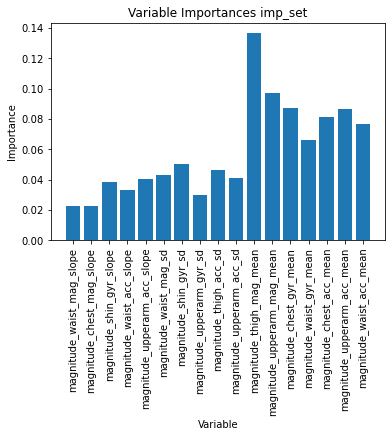

In [29]:
importance_features(imp_m, imp_X, 'imp_set')

In [13]:
# !!! RUN !!!
#do this with balanced model
best_grid = RandomForestClassifier(max_depth=50, max_features=3, min_samples_leaf=3, 
                                  min_samples_split=8, n_estimators=200, class_weight='balanced')

In [27]:
#put it all together
columns_imp = ['magnitude_waist_mag_slope', 'magnitude_chest_mag_slope', 'magnitude_shin_gyr_slope', 'magnitude_waist_acc_slope',
                 'magnitude_upperarm_acc_slope', 'magnitude_waist_mag_sd', 'magnitude_shin_gyr_sd', 'magnitude_upperarm_gyr_sd', 'magnitude_thigh_acc_sd',
                 'magnitude_upperarm_acc_sd', 'magnitude_thigh_mag_mean', 'magnitude_upperarm_mag_mean', 'magnitude_chest_gyr_mean', 'magnitude_waist_gyr_mean',
                 'magnitude_chest_acc_mean', 'magnitude_upperarm_acc_mean', 'magnitude_waist_acc_mean', 'Activity']
imp_set = new_subset[columns_imp]
imp_m, imp_X = rf_model_new(best_grid, imp_set)
importance_features(imp_m, imp_X, 'imp_set')

(4847731, 17)
(4847731,)
(1211933, 17)
(1211933,)
Mean Absolute Error: 0.06 degrees.
[[115613   2609     82      0    520     30     66   1596]
 [  2404 132266     11      0     86     17    149   2913]
 [   112      2  20250      0    348      0      5      0]
 [   162    630      3 182470     81    149    524     42]
 [   990    358     88      6 193969    151   1925    319]
 [    32    319      0     20     57 181743   1455     36]
 [     4     96      0      9     31    142 181541     47]
 [  1662   1515      4      3     74     66    266 181865]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    120516
           1       0.96      0.96      0.96    137846
           2       0.99      0.98      0.98     20717
           3       1.00      0.99      1.00    184061
           4       0.99      0.98      0.99    197806
           5       1.00      0.99      0.99    183662
           6       0.98      1.00      0.99    181870
         

ValueError: too many values to unpack (expected 2)

Variable: magnitude_upperarm_acc_mean Importance: 0.13
Variable: magnitude_thigh_mag_mean Importance: 0.11
Variable: magnitude_chest_gyr_mean Importance: 0.1
Variable: magnitude_upperarm_mag_mean Importance: 0.08
Variable: magnitude_chest_acc_mean Importance: 0.08
Variable: magnitude_upperarm_acc_sd Importance: 0.07
Variable: magnitude_waist_gyr_mean Importance: 0.07
Variable: magnitude_waist_acc_mean Importance: 0.07
Variable: magnitude_shin_gyr_sd Importance: 0.06
Variable: magnitude_thigh_acc_sd Importance: 0.06
Variable: magnitude_upperarm_acc_slope Importance: 0.04
Variable: magnitude_upperarm_gyr_sd Importance: 0.04
Variable: magnitude_shin_gyr_slope Importance: 0.02
Variable: magnitude_waist_acc_slope Importance: 0.02
Variable: magnitude_waist_mag_sd Importance: 0.02
Variable: magnitude_waist_mag_slope Importance: 0.01
Variable: magnitude_chest_mag_slope Importance: 0.01


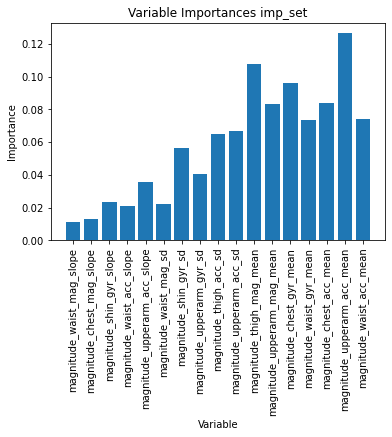

In [28]:
importance_features(imp_m, imp_X, 'imp_set')